# Aversion au risque

On load quelques modules...

In [1]:
import numpy as np
from matplotlib import pyplot as plt

Ce notebook permet de faire 3 choses: 
1. Comment définir une fonction d'utilité
2. Comment gérer le risque
3. Calculer prime de risque
4. Comment évaluer une assurance-auto

## Fonctions d'utilité

On va faire une fonction d'utilité qu'on dit CRRA: 
$$ u(c) = \frac{c^{1-\sigma}}{1-\sigma} $$

In [2]:
def crra(w,gamma):
    if gamma==1.0:
        return np.log(w)
    else :
        return (w**(1-gamma)-1.0)/(1.0-gamma)



On va aussi définir l'inverse de cette fonction:

In [3]:
def invcrra(u,gamma):
    if sigma==1.0:
        return np.exp(w)
    else :
        return (u*(1.0-gamma)+1.0)**(1.0/(1.0-gamma))



Regardons comment cette fonction se comporte...

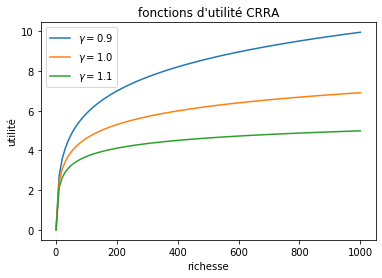

In [4]:
ws = np.linspace(1,1e3,100)
gammas = [0.9,1.0,1.1]
plt.figure()
for gamma in gammas:
    plt.plot(ws,crra(ws,gamma),label='$\\gamma=$'+str(gamma))
plt.xlabel('richesse')
plt.ylabel('utilité')
plt.title('fonctions d\'utilité CRRA')
plt.legend()
plt.savefig('crra_plot.png')


## Gérer le risque

In [5]:
from scipy.stats import norm, lognorm, chi2

### tirages aléatoires

(array([  5.,  48., 126., 197., 232., 204., 120.,  53.,  12.,   3.]),
 array([-2.86593846, -2.23680363, -1.6076688 , -0.97853397, -0.34939914,
         0.27973569,  0.90887052,  1.53800535,  2.16714018,  2.796275  ,
         3.42540983]),
 <a list of 10 Patch objects>)

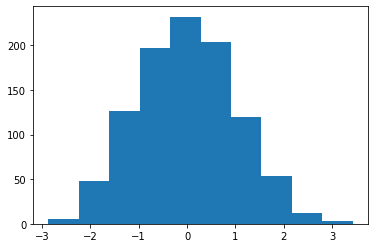

In [6]:
x = norm(0,1).rvs(1000)
plt.hist(x)

### fonctions de répartion (cdf) et densité (pdf)

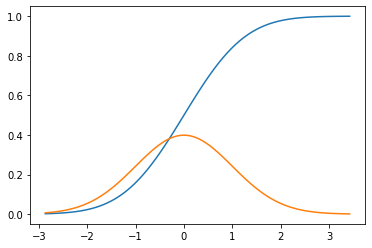

In [7]:
x = np.linspace(np.min(x),np.max(x),100)
plt.figure()
plt.plot(x,norm(0,1).cdf(x))
plt.plot(x,norm(0,1).pdf(x))


### fonction de répartition inverse

p = norm(0,1).cdf(x)
plt.figure()
plt.plot(norm(0,1).ppf(p),p)

## Distribution strictement positive

In [8]:
mu = 1000.0
sig = 300.0

In [9]:
def loss(mu,sig,S):
    draws = np.exp(norm(np.log(mu),(1/np.sqrt(sig))*np.log(sig)).rvs(S))
    return  draws - 0.5*((1/np.sqrt(sig))*np.log(sig))**2

In [10]:
L = loss(mu,sig,10000)

In [11]:
np.mean(L),np.std(L)

(1052.649460246892, 355.9787650696567)

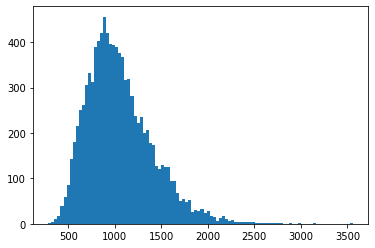

In [12]:
plt.figure()
plt.hist(L,bins=100)
plt.show()

### Utilité espérée (en utilisant simulation)

In [13]:
S = 10000
sig = 1000
eps = norm(0,sig).rvs(S)
wealth = 50e3
eu = np.mean([crra(wealth+e,gamma) for e in eps])
eu

6.6107546197611144

In [14]:
def eucrra(wealth,gamma,eps):
    return np.mean([crra(wealth+e,gamma) for e in eps])

Text(0, 0.5, "espérance d'utilité")

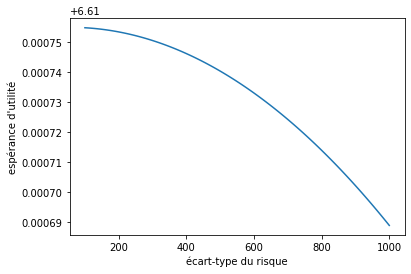

In [15]:
sigs = np.linspace(100.0,1000.0,100)
eus = []
eps = norm(0,1).rvs(S)
for sig in sigs:
    eus.append(eucrra(wealth,gamma,sig*eps))
plt.figure()
plt.plot(sigs,eus)
plt.xlabel('écart-type du risque')
plt.ylabel('espérance d\'utilité')

## Disposition à payer (prime de risque)

On peut trouver la prime $\pi$ tel que : 
$$ u(w-\pi) - Eu(w+\epsilon) = 0$$

Des algorithmes peuvent nous aider à résoudre dans des situations générales.
Un de ces algorithmes est la méthode de Brent. 
https://en.wikipedia.org/wiki/Brent%27s_method

In [16]:
def solve(pi,wealth,gamma,eps):
    u = crra(wealth-pi,gamma)
    eu = eucrra(wealth,gamma,eps)
    return eu-u 

In [17]:
from scipy.optimize import brentq
S = 100000
sig = 1000.0
eps = norm(0,1).rvs(S)
wealth = 20e3
brentq(solve, 1.0, 0.95*wealth,args=(wealth,gamma,sig*eps))


34.76902279111458

Le consommateur veut payer ce montant pour éviter le risque. 

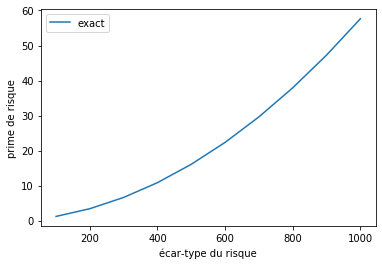

In [18]:
pis = []
sigs = np.linspace(100.0,1000.0,10)
gamma = 2.0
for sig in sigs:
    pis.append(brentq(solve, 0.0, wealth*0.95, args=(wealth,gamma,sig*eps)))
plt.figure()
plt.plot(sigs,pis,label='exact')
plt.xlabel('écar-type du risque')
plt.ylabel('prime de risque')
plt.legend()

## Exemple: Disposition à payer assurance-auto

Supposons un véhicule qui a une valeur de 50,000\\$. Votre compagnie d'assurance vous offre une police d'assurance au coût de 300\\$ avec un déductible de 500\\$. La probabilité d'un accident pour ce genre de véhicule est 5 sur 100. S'il y a un accident, le coût des réparations est distribué log-normal avec une moyenne de 5000\$ et un écart-type de 5000\\$. 

Analysons d'abord le risque. Quelle est la perte espérée?

In [19]:
from scipy.stats import norm,uniform,lognorm
wealth = 50e3
mu = 5e3
sig = 0.75
p = 0.05
S = 100000

s = sig 
scale = mu
Lc = lognorm(loc=np.log(mu),scale=scale,s=s).rvs(S)
Lc = np.where(Lc>wealth,wealth*0.99,Lc)
u = uniform(0,1).rvs(S)
eps = np.where(u<p,1.0,0.0)
L = np.multiply(Lc,eps)

In [20]:
np.mean(Lc),np.std(Lc),np.max(Lc)

(6599.935963212234, 5583.292275768353, 49985.80383527318)

In [21]:
np.mean(L),np.std(L),np.max(L)

(323.75520499102413, 1877.0716507679872, 49500.0)

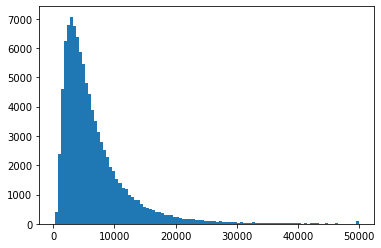

In [22]:
plt.figure()
plt.hist(Lc,bins=100)
plt.show()

Donc, ce risque implique une perte moyenne de 384\\$ avec un écart-type de 2135\\$. La couverture de l'assureur comporte un deductible. Donc l'assureur indemnise $I = \max(L-d,0)$ ou $d$ est le déductible. 

In [23]:
d = 500.0
prime = 400.0
I = np.where((L - d)>0,L-d,0.0)
np.mean(I)

298.70662959307583

L'assureur vend la police 500\\$ alors que la prime qui serait juste du point de vue actuariel serait 354\\$. Donc, il fait un profit sur cette assurance. Est-ce que vous l'acheter? Ca dépend de votre aversion au risque. 

Il faut calculer la disposition à payer

In [24]:
def solve(wtp,wealth,gamma,L,I):
    eu_n = eucrra(wealth,gamma,-L)
    eu_i = eucrra(wealth-wtp,gamma,-L+I)
    return eu_i-eu_n

In [25]:
gamma = 1.5
brentq(solve, 0.0, 1000.0,args=(wealth,gamma,L,I))

436.31529649746017

On le fait pour plusieurs valeurs de l'aversion au risque:

In [26]:
gammas = np.linspace(0.5,2.0,10)
wtps = []
for gamma in gammas:
    opt = brentq(solve, 0.0, 1000.0,args=(wealth,gamma,L,I))
    wtps.append(opt)

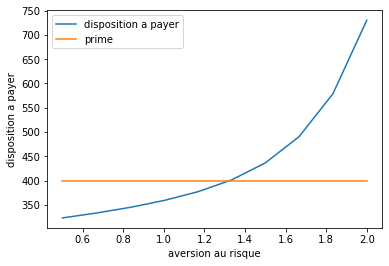

In [27]:
plt.figure()
plt.plot(gammas,wtps,label='disposition a payer')
plt.plot(gammas,prime*np.ones(len(gammas)),label='prime')
plt.xlabel('aversion au risque')
plt.ylabel('disposition a payer')
plt.legend()
plt.show()

On remarque qu'un individu qui a une aversion au risque trop faible ne devrait pas acheter l'assurance (sa disposition à payer est plus faible que la prime). 